In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_curve, auc
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = None
#pd.set_option('display.max_rows', None)


Посмотрим на датасет, как распределены признаки в нём, почистим и приведём данные в надлежащий вид

In [2]:
data=pd.read_excel("Задание (пролонгация).xlsx", sheet_name = 'data_full')
df=data
df.head(5)

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,KBM,KBM_prol_est,delta_kbm,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,1,Магнитогорский,Иностранные,Челябинская область,NaN,TOYOTA,RAV 4,2018,Нет,Состоит в браке,8,6,-2,Франшиза 2-ой страховой случай,20000+,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,42,24,1.00,1400000,M,0,55000,0.040,0,0
1,2,Магнитогорский,Отечественные,Челябинская область,NaN,LADA,GRANTA,2016,Нет,Состоит в браке,8,6,-2,Без франшизы,0,Компакт,Банк,Автосалоны,RN,Водители согласно перечню,41,4,1.05,200000,M,0,10000,0.010,0,0
2,3,Ростовский,Отечественные,Ростовская область,NaN,LADA,GRANTA,2018,Нет,Не состоит в браке,8,6,-2,Без франшизы,0,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,49,20,0.95,400000,F,0,30000,0.065,1,1
3,4,Казанский,Иностранные,Республика Татарстан,NaN,KIA,RIO,2016,Нет,Не состоит в браке,8,6,-2,Без франшизы,0,Компакт,Сетелем,Автосалоны,RN,Водители согласно перечню,40,15,1.10,400000,M,0,10000,0.020,1,0
4,5,Московский,Иностранные,Москва,NaN,DATSUN,ON-DO,2018,Нет,Состоит в браке,8,6,-2,Без франшизы,0,Компакт,Без банка,Розница,NB 0-1,Водители согласно перечню,58,23,1.00,400000,M,0,10000,0.015,0,0


In [3]:
description=pd.read_excel("Задание (пролонгация).xlsx", sheet_name = 'Переменные')
description.head(40)

,id,ID договора
0,Filial,Филиал продажи
1,Type_ts,Тип ТС
2,passport_region,Регион по серии паспорта
3,VIP,VIP клиент
4,Brand,Марка ТС
5,Model,Модель ТС
6,Yr_production,Год выпуска ТС
7,GAP,GAP застрахован
8,married,Брак
9,KBM,КБМ


In [4]:
#Проверим, имеются ли в датасете повторяющиеся ID 
display(len(df))
display(len(df.ID.unique()))

10863

10863

In [5]:
df.describe()

,ID,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,premium_car,price_gr,price_prc,OSAGO_clnt,target
count,10863.000000,10863.000000,10863.000000,10863.000000,10863.000000,10863.000000,10863.000000,10863.000000,1.086300e+04,10863.000000,10863.000000,10863.000000,10863.000000,10863.000000
mean,5432.000000,2016.940624,7.058639,5.195986,-5.066188,43.680567,17.244408,1.000101,9.775016e+05,0.087453,32812.298628,0.033307,0.586118,-0.082206
std,3136.022321,1.546633,1.922778,1.735655,17.274537,11.252854,9.603299,0.050590,6.782969e+05,0.282510,19670.537786,0.016956,0.492551,0.715686
min,1.000000,2009.000000,0.000000,0.000000,-100.000000,18.000000,0.000000,0.900000,0.000000e+00,0.000000,10000.000000,0.000000,0.000000,-1.000000
25%,2716.500000,2016.000000,6.000000,5.000000,-2.000000,35.000000,10.000000,1.000000,6.000000e+05,0.000000,15000.000000,0.020000,0.000000,-1.000000
50%,5432.000000,2018.000000,8.000000,6.000000,-2.000000,42.000000,16.000000,1.000000,8.000000e+05,0.000000,30000.000000,0.030000,1.000000,0.000000
75%,8147.500000,2018.000000,8.000000,6.000000,-2.000000,52.000000,22.000000,1.000000,1.200000e+06,0.000000,45000.000000,0.045000,1.000000,0.000000
max,10863.000000,2018.000000,12.000000,10.000000,2.000000,84.000000,63.000000,1.100000,3.000000e+06,1.000000,70000.000000,0.100000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863 entries, 0 to 10862
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10863 non-null  int64  
 1   Filial           10863 non-null  object 
 2   Type_ts          10863 non-null  object 
 3   passport_region  10863 non-null  object 
 4   VIP              284 non-null    object 
 5   Brand            10863 non-null  object 
 6   Model            10863 non-null  object 
 7   Yr_production    10863 non-null  int64  
 8   GAP              10863 non-null  object 
 9   married          10863 non-null  object 
 10  KBM              10863 non-null  int64  
 11  KBM_prol_est     10863 non-null  int64  
 12  delta_kbm        10863 non-null  int64  
 13  deduct           10863 non-null  object 
 14  deduct_amount    10863 non-null  object 
 15  product          10863 non-null  object 
 16  Bank             10863 non-null  object 
 17  channel - ma

In [7]:
display(df.isna().sum())
display(df.isnull().sum())

ID                     0
Filial                 0
Type_ts                0
passport_region        0
VIP                10579
Brand                  0
Model                  0
Yr_production          0
GAP                    0
married                0
KBM                    0
KBM_prol_est           0
delta_kbm              0
deduct                 0
deduct_amount          0
product                0
Bank                   0
channel - map          0
category               0
kvs_type               0
Age                    0
Exp                    0
discount               0
Amount - gr            0
sex                    0
premium_car            0
price_gr               0
price_prc              0
OSAGO_clnt             0
target                 0
dtype: int64

ID                     0
Filial                 0
Type_ts                0
passport_region        0
VIP                10579
Brand                  0
Model                  0
Yr_production          0
GAP                    0
married                0
KBM                    0
KBM_prol_est           0
delta_kbm              0
deduct                 0
deduct_amount          0
product                0
Bank                   0
channel - map          0
category               0
kvs_type               0
Age                    0
Exp                    0
discount               0
Amount - gr            0
sex                    0
premium_car            0
price_gr               0
price_prc              0
OSAGO_clnt             0
target                 0
dtype: int64

Классы разбалансированы, о чём свидетельствует разница в наполненности классов более чем в 2 раза

In [8]:
df.target.value_counts()

 0    5226
-1    3265
 1    2372
Name: target, dtype: int64

In [9]:
df['VIP']=df['VIP'].fillna('NotVIP')
df.VIP.value_counts()

NotVIP             10579
Особый статус +      201
Особый статус         83
Name: VIP, dtype: int64

In [10]:
for i in df.columns[1:]:
    x = df[i].value_counts()
    display("Column name is:",i,"and it value is:",x)

'Column name is:'

'Filial'

'and it value is:'

Московский               3305
Краснодарский            1153
Санкт - Петербургский    1086
Ростовский                553
Воронежский               474
Казанский                 421
Самарский                 394
Магнитогорский            335
Челябинский               320
Пермский                  307
Ижевский                  276
Уфимский                  270
Нижегородский             269
Тверской                  251
Екатеринбургский          243
Ставропольский            234
Волгоградский             232
Новосибирский             186
Белгородский              182
Кемеровский               171
Тульский                  134
Дальневосточный            67
Name: Filial, dtype: int64

'Column name is:'

'Type_ts'

'and it value is:'

Иностранные      8353
Отечественные    2510
Name: Type_ts, dtype: int64

'Column name is:'

'passport_region'

'and it value is:'

Москва                          1611
Московская область              1164
Краснодарский край               936
Санкт-Петербург                  739
Ростовская область               544
                                ... 
Еврейская автономная область       2
Чеченская Республика               2
Магаданская область                2
Республика Ингушетия               1
Ненецкий автономный округ          1
Name: passport_region, Length: 85, dtype: int64

'Column name is:'

'VIP'

'and it value is:'

NotVIP             10579
Особый статус +      201
Особый статус         83
Name: VIP, dtype: int64

'Column name is:'

'Brand'

'and it value is:'

LADA             2178
KIA              1879
HYUNDAI          1509
VOLKSWAGEN        956
TOYOTA            649
NISSAN            555
SKODA             540
RENAULT           481
FORD              453
CHEVROLET         267
MITSUBISHI        201
MERCEDES-BENZ     188
MAZDA             169
BMW               144
AUDI              134
DATSUN            131
LEXUS             114
UAZ               102
VOLVO              55
SUBARU             52
HONDA              46
LAND ROVER         42
PORSCHE            18
Name: Brand, dtype: int64

'Column name is:'

'Model'

'and it value is:'

RIO             914
GRANTA          728
SOLARIS         631
VESTA           612
CRETA           539
               ... 
OUTLANDER XL      1
PILOT             1
QASHQAI+2         1
CX-9              1
7-СЕРИЯ           1
Name: Model, Length: 200, dtype: int64

'Column name is:'

'Yr_production'

'and it value is:'

2018    5521
2017    2585
2016    1333
2015     468
2014     410
2013     254
2012     162
2011      78
2010      43
2009       9
Name: Yr_production, dtype: int64

'Column name is:'

'GAP'

'and it value is:'

Нет    9749
Да     1114
Name: GAP, dtype: int64

'Column name is:'

'married'

'and it value is:'

Состоит в браке       8491
Не состоит в браке    2372
Name: married, dtype: int64

'Column name is:'

'KBM'

'and it value is:'

8     7924
6     1329
4      592
0      348
2      193
7      188
5      150
3       57
1       55
9       12
10      10
12       3
11       2
Name: KBM, dtype: int64

'Column name is:'

'KBM_prol_est'

'and it value is:'

6     7478
4     1278
0      588
2      568
7      416
5      228
3      167
1       60
9       41
8       22
10      17
Name: KBM_prol_est, dtype: int64

'Column name is:'

'delta_kbm'

'and it value is:'

-2      9865
-1       577
-100     348
 1        45
 0        14
 2        14
Name: delta_kbm, dtype: int64

'Column name is:'

'deduct'

'and it value is:'

Без франшизы                      7148
Безусловная франшиза              2689
Франшиза 2-ой страховой случай    1026
Name: deduct, dtype: int64

'Column name is:'

'deduct_amount'

'and it value is:'

0         7148
20000-    2010
20000+    1705
Name: deduct_amount, dtype: int64

'Column name is:'

'product'

'and it value is:'

Классика     7703
Компакт      2243
Уверенный     638
Legacy        279
Name: product, dtype: int64

'Column name is:'

'Bank'

'and it value is:'

Банк         5831
Без банка    3424
Сетелем      1608
Name: Bank, dtype: int64

'Column name is:'

'channel - map'

'and it value is:'

Автосалоны    8412
Розница       2451
Name: channel - map, dtype: int64

'Column name is:'

'category'

'and it value is:'

NB 0-1     6079
RN         3706
RN sppg     590
NB 2+       488
Name: category, dtype: int64

'Column name is:'

'kvs_type'

'and it value is:'

Водители согласно перечню                                          10753
Ограничение по стажу и возрасту, без ограничения количества лиц      110
Name: kvs_type, dtype: int64

'Column name is:'

'Age'

'and it value is:'

40    397
35    391
36    377
38    371
34    368
     ... 
81      3
83      2
82      1
80      1
84      1
Name: Age, Length: 67, dtype: int64

'Column name is:'

'Exp'

'and it value is:'

10    606
18    571
11    534
17    501
12    479
9     470
15    444
13    441
16    436
19    435
8     407
20    400
14    388
21    373
7     346
23    292
6     285
22    276
5     259
24    243
4     231
25    191
26    179
27    171
28    166
3     130
31    128
29    124
32    109
33    109
30    101
34    100
37     93
35     88
2      87
36     76
38     74
40     73
39     63
1      63
0      59
42     57
41     43
43     35
44     24
46     24
45     21
48     16
47     15
49      6
52      6
51      5
50      3
53      3
60      2
63      1
54      1
Name: Exp, dtype: int64

'Column name is:'

'discount'

'and it value is:'

1.00    6427
1.05    1137
0.90    1125
1.10    1103
0.95    1071
Name: discount, dtype: int64

'Column name is:'

'Amount - gr'

'and it value is:'

600000     2274
400000     1945
800000     1591
1000000     978
1200000     729
1400000     716
200000      647
1600000     470
3000000     422
1800000     363
2000000     242
2200000     151
2600000     114
2400000      96
2800000      73
0            52
Name: Amount - gr, dtype: int64

'Column name is:'

'sex'

'and it value is:'

M    7185
F    3673
        5
Name: sex, dtype: int64

'Column name is:'

'premium_car'

'and it value is:'

0    9913
1     950
Name: premium_car, dtype: int64

'Column name is:'

'price_gr'

'and it value is:'

10000    2134
70000    1152
25000    1060
20000     998
15000     998
30000     949
35000     876
40000     689
45000     542
50000     513
55000     393
60000     330
65000     229
Name: price_gr, dtype: int64

'Column name is:'

'price_prc'

'and it value is:'

0.030    1404
0.025    1393
0.020    1314
0.035    1216
0.040     978
0.015     909
0.045     748
0.010     615
0.050     595
0.055     431
0.060     335
0.005     248
0.065     217
0.070     147
0.075     101
0.080      68
0.085      44
0.100      30
0.090      27
0.095      22
0.000      21
Name: price_prc, dtype: int64

'Column name is:'

'OSAGO_clnt'

'and it value is:'

1    6367
0    4496
Name: OSAGO_clnt, dtype: int64

'Column name is:'

'target'

'and it value is:'

 0    5226
-1    3265
 1    2372
Name: target, dtype: int64

Данные "грязные". В частности, в некоторых ячейках в колонке "пол" стоит пробел. Заменим их на наиболее часто встречающееся значение (моду) пола для данной модели автомобиля. 
В некоторых ячейках в колонке passport_region стоит "н.д.". Заменим его на наиболее часто встречающееся значение (моду) региона по паспорту в данном филиале.

In [11]:
for Model in df.Model.unique():
    c1= df.Model == Model
    c2= df.sex == ' '
    df.loc[c1&c2, 'sex'] = df.loc[c1, 'sex'].mode()[0]
for Filial in df.Filial.unique():
    c1= df.Filial == Filial
    c2= df.passport_region == 'н.д.'
    df.loc[c1&c2, 'passport_region'] = df.loc[c1, 'passport_region'].mode()[0]

#### Закодируем переменные. 

In [12]:
display(df.dtypes)


ID                   int64
Filial              object
Type_ts             object
passport_region     object
VIP                 object
Brand               object
Model               object
Yr_production        int64
GAP                 object
married             object
KBM                  int64
KBM_prol_est         int64
delta_kbm            int64
deduct              object
deduct_amount       object
product             object
Bank                object
channel - map       object
category            object
kvs_type            object
Age                  int64
Exp                  int64
discount           float64
Amount - gr          int64
sex                 object
premium_car          int64
price_gr             int64
price_prc          float64
OSAGO_clnt           int64
target               int64
dtype: object

Для типа франшизы введём ренговые значения: самый лучший вариант - без франшизы (2), худший - безусловная франшиза (0).  
Для размера франшизы заменим границу на среднее значение в диапазонах 0-20000, 20001+

In [13]:
df['deduct']=df['deduct'].replace({'Без франшизы': '2', 'Франшиза 2-ой страховой случай': '1','Безусловная франшиза': '0'}).astype(int)
df['deduct_amount']=df['deduct_amount'].replace({'20000+': '30000', '20000-': '10000'}).astype(int)

In [14]:
df[['Type_ts','GAP','married','channel - map', 'kvs_type','sex']]=\
pd.get_dummies((df[['Type_ts','GAP','married','channel - map', 'kvs_type','sex']]), drop_first=True)
df.head()

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,KBM,KBM_prol_est,delta_kbm,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,1,Магнитогорский,0,Челябинская область,NotVIP,TOYOTA,RAV 4,2018,1,1,8,6,-2,1,30000,Классика,Банк,0,NB 0-1,0,42,24,1.00,1400000,1,0,55000,0.040,0,0
1,2,Магнитогорский,1,Челябинская область,NotVIP,LADA,GRANTA,2016,1,1,8,6,-2,2,0,Компакт,Банк,0,RN,0,41,4,1.05,200000,1,0,10000,0.010,0,0
2,3,Ростовский,1,Ростовская область,NotVIP,LADA,GRANTA,2018,1,0,8,6,-2,2,0,Классика,Банк,0,NB 0-1,0,49,20,0.95,400000,0,0,30000,0.065,1,1
3,4,Казанский,0,Республика Татарстан,NotVIP,KIA,RIO,2016,1,0,8,6,-2,2,0,Компакт,Сетелем,0,RN,0,40,15,1.10,400000,1,0,10000,0.020,1,0
4,5,Московский,0,Москва,NotVIP,DATSUN,ON-DO,2018,1,1,8,6,-2,2,0,Компакт,Без банка,1,NB 0-1,0,58,23,1.00,400000,1,0,10000,0.015,0,0


In [15]:
df[['Amount - gr']].value_counts()

Amount - gr
600000         2274
400000         1945
800000         1591
1000000         978
1200000         729
1400000         716
200000          647
1600000         470
3000000         422
1800000         363
2000000         242
2200000         151
2600000         114
2400000          96
2800000          73
0                52
dtype: int64

In [16]:
le_Filial = preprocessing.LabelEncoder()
le_Filial.fit(df['Filial'])
#list(le_Filial.classes_)
Filial=le_Filial.transform(df['Filial'])
df['Filial']=Filial


le_passport_region = preprocessing.LabelEncoder()
le_passport_region.fit(df['passport_region'])
passport_region=le_passport_region.transform(df['passport_region'])
df['passport_region']=passport_region


le_VIP = preprocessing.LabelEncoder()
le_VIP.fit(df['VIP'])
VIP=le_VIP.transform(df['VIP'])
df['VIP']=VIP

le_Brand = preprocessing.LabelEncoder()
le_Brand.fit(df['Brand'])
Brand=le_Brand.transform(df['Brand'])
df['Brand']=Brand


df['Model']=df['Model'].astype(str)
le_Model = preprocessing.LabelEncoder()
le_Model.fit(df['Model'])
Model=le_Model.transform(df['Model'])
df['Model']=Model


le_product = preprocessing.LabelEncoder()
le_product.fit(df['product'])
product=le_product.transform(df['product'])
df['product']=product


le_Bank = preprocessing.LabelEncoder()
le_Bank.fit(df['Bank'])
Bank=le_Bank.transform(df['Bank'])
df['Bank']=Bank

le_category = preprocessing.LabelEncoder()
le_category.fit(df['category'])
category=le_category.transform(df['category'])
df['category']=category

df.head(2)

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,KBM,KBM_prol_est,delta_kbm,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,1,9,0,78,0,19,146,2018,1,1,8,6,-2,1,30000,1,0,0,0,0,42,24,1.00,1400000,1,0,55000,0.04,0,0
1,2,9,1,78,0,8,79,2016,1,1,8,6,-2,2,0,2,0,0,2,0,41,4,1.05,200000,1,0,10000,0.01,0,0


<AxesSubplot:>

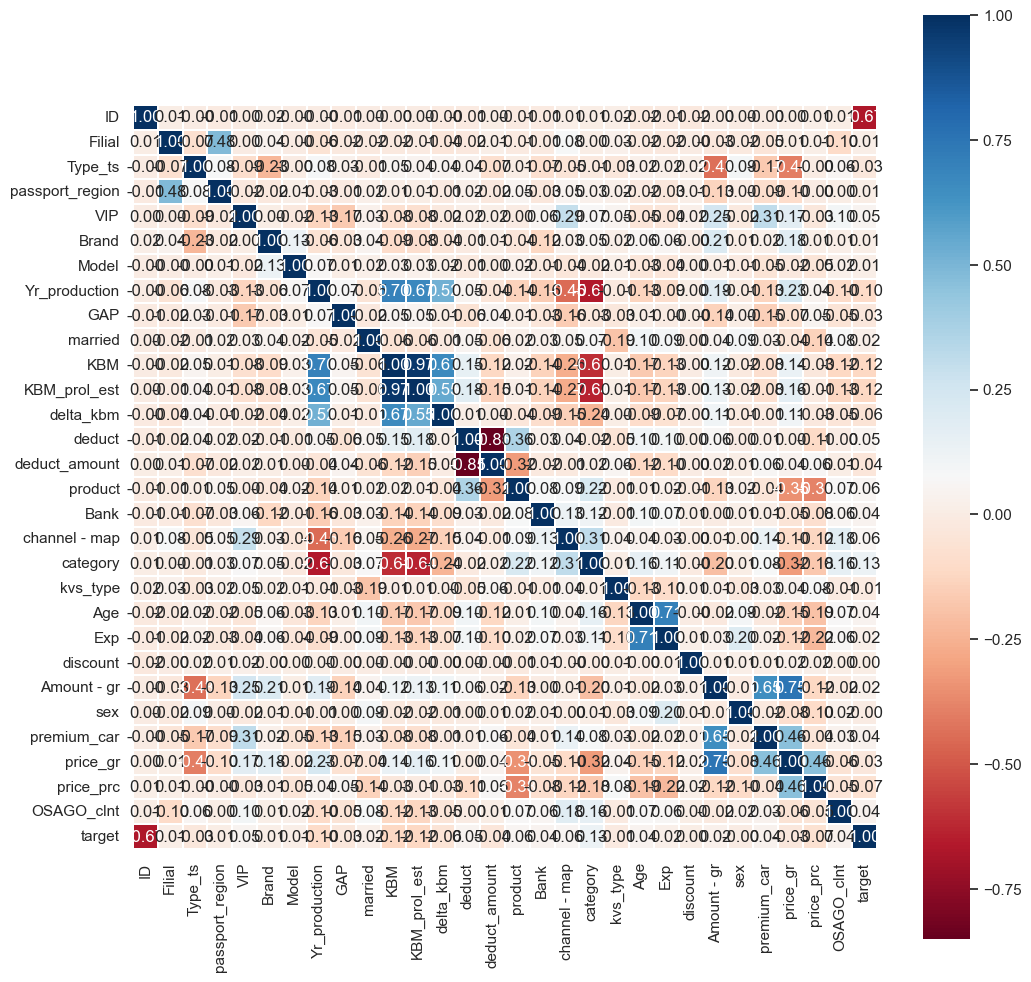

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), square=True,
              annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu")


In [18]:
df.head()

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,KBM,KBM_prol_est,delta_kbm,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,1,9,0,78,0,19,146,2018,1,1,8,6,-2,1,30000,1,0,0,0,0,42,24,1.00,1400000,1,0,55000,0.040,0,0
1,2,9,1,78,0,8,79,2016,1,1,8,6,-2,2,0,2,0,0,2,0,41,4,1.05,200000,1,0,10000,0.010,0,0
2,3,14,1,60,0,8,79,2018,1,0,8,6,-2,2,0,1,0,0,0,0,49,20,0.95,400000,0,0,30000,0.065,1,1
3,4,6,0,57,0,7,147,2016,1,0,8,6,-2,2,0,2,2,0,2,0,40,15,1.10,400000,1,0,10000,0.020,1,0
4,5,10,0,30,0,3,117,2018,1,1,8,6,-2,2,0,2,1,1,0,0,58,23,1.00,400000,1,0,10000,0.015,0,0


In [19]:
df.dtypes

ID                   int64
Filial               int32
Type_ts              uint8
passport_region      int32
VIP                  int32
Brand                int32
Model                int32
Yr_production        int64
GAP                  uint8
married              uint8
KBM                  int64
KBM_prol_est         int64
delta_kbm            int64
deduct               int32
deduct_amount        int32
product              int32
Bank                 int32
channel - map        uint8
category             int32
kvs_type             uint8
Age                  int64
Exp                  int64
discount           float64
Amount - gr          int64
sex                  uint8
premium_car          int64
price_gr             int64
price_prc          float64
OSAGO_clnt           int64
target               int64
dtype: object

### Вспомогательный регрессор 
Так как имееется 52 строки, в которых Amount - gr равняется 0, построим дополнительный классификатор, предсказывающий корректное значение Amount - gr. 

In [20]:
df.columns

Index(['ID', 'Filial', 'Type_ts', 'passport_region', 'VIP', 'Brand', 'Model',
       'Yr_production', 'GAP', 'married', 'KBM', 'KBM_prol_est', 'delta_kbm',
       'deduct', 'deduct_amount', 'product', 'Bank', 'channel - map',
       'category', 'kvs_type', 'Age', 'Exp', 'discount', 'Amount - gr', 'sex',
       'premium_car', 'price_gr', 'price_prc', 'OSAGO_clnt', 'target'],
      dtype='object')

In [21]:
df['Amount - gr'].unique()

array([1400000,  200000,  400000, 3000000,  600000, 1000000, 2000000,
       1800000,  800000, 1600000, 1200000, 2200000, 2400000, 2600000,
       2800000,       0], dtype=int64)

In [22]:
df_gr=df[['Filial','Brand', 'Model', 'Yr_production','channel - map', 'Amount - gr']]
train_gr=df_gr[df_gr['Amount - gr']!=0]
test_gr=df_gr[df_gr['Amount - gr']==0]
y_train_gr=train_gr['Amount - gr']
x_train_gr=train_gr.drop(['Amount - gr'], axis = 1) 
x_test_gr=test_gr.drop(['Amount - gr'], axis = 1) 

df_gr.head(5)

,Filial,Brand,Model,Yr_production,channel - map,Amount - gr
0,9,19,146,2018,0,1400000
1,9,8,79,2016,0,200000
2,14,8,79,2018,0,400000
3,6,7,147,2016,0,400000
4,10,3,117,2018,1,400000


In [23]:
#from sklearn.linear_model import Ridge
#from sklearn.metrics import mean_squared_error
#ridge = Ridge(alpha=1000).fit(x_train_gr, y_train_gr)
#mean_squared_error(ridge.predict(x_test_gr), y_test)
#from sklearn.model_selection import GridSearchCV

#grid_searcher = GridSearchCV(Ridge(),
 #                            param_grid={'alpha': np.linspace(100, 750, 10)},
  #                           cv=5).fit(x_train_gr, y_train_gr)
#mean_squared_error(grid_searcher.predict(x_test_gr), y_test)
#grid_searcher.best_params_


In [24]:
df[df['Amount - gr']==0]

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,KBM,KBM_prol_est,delta_kbm,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
184,185,5,1,74,0,8,79,2014,1,1,2,0,-2,0,10000,1,2,0,2,0,50,4,0.95,0,1,0,10000,0.060,1,0
631,632,10,0,30,0,16,103,2009,1,0,0,0,-100,2,0,1,1,0,2,0,40,21,1.05,0,1,0,20000,0.100,1,1
668,669,18,1,70,0,2,113,2010,1,1,8,6,-2,2,0,2,1,1,1,0,56,22,0.90,0,1,0,10000,0.010,1,0
896,897,15,1,62,0,8,4,2011,1,1,8,6,-2,2,0,2,1,1,3,0,42,13,1.00,0,1,0,10000,0.010,1,0
951,952,15,1,62,0,8,79,2015,1,1,4,2,-2,0,30000,1,0,1,2,0,53,26,1.00,0,1,0,10000,0.040,1,1
1213,1214,15,1,62,0,8,79,2015,1,1,8,6,-2,2,0,2,1,0,1,0,67,24,1.05,0,1,0,10000,0.015,1,0
1735,1736,15,1,62,0,8,135,2016,1,1,8,6,-2,2,0,2,1,0,1,0,30,11,1.00,0,0,0,10000,0.005,1,0
1967,1968,18,1,70,0,8,91,2017,1,1,8,6,-2,2,0,2,1,1,2,0,33,15,1.00,0,1,0,10000,0.010,1,1
2505,2506,14,1,23,0,8,79,2017,1,1,8,6,-2,2,0,2,0,0,2,0,38,17,1.00,0,0,0,10000,0.020,0,1
2631,2632,18,0,70,0,16,161,2010,1,1,8,6,-2,2,0,2,1,1,1,0,63,42,0.90,0,1,0,10000,0.035,1,0


### Разделение датасета на train test

In [25]:
train=df[df['target']!=-1]
test=df[df['target']==-1]
y=train['target']
x=train.drop(['target'], axis = 1) 
x_test=test.drop(['target'], axis = 1) 


Обучим классификатор

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
clf_rf=RandomForestClassifier()
parametrs={'n_estimators':[10, 20, 30], 'max_depth':[2, 5, 7, 10]}
grid_search_cv_clf= GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train )
grid_search_cv_clf.best_params_

{'max_depth': 7, 'n_estimators': 30}

In [27]:
best_clf=grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)


0.7312599681020734

In [28]:
feature_importances=best_clf.feature_importances_
feature_importances_df=pd.DataFrame({
    'features': list(X_train),
    'feature_importances': feature_importances
})
print(len(list(X_train)),    feature_importances.shape)

29 (29,)


In [29]:
feature_importances_df.sort_values('feature_importances', ascending=False )

,features,feature_importances
18,category,0.151238
10,KBM,0.082099
7,Yr_production,0.079502
11,KBM_prol_est,0.069105
27,price_prc,0.067525
16,Bank,0.054875
0,ID,0.047769
20,Age,0.040102
21,Exp,0.039291
23,Amount - gr,0.036503


<AxesSubplot:>

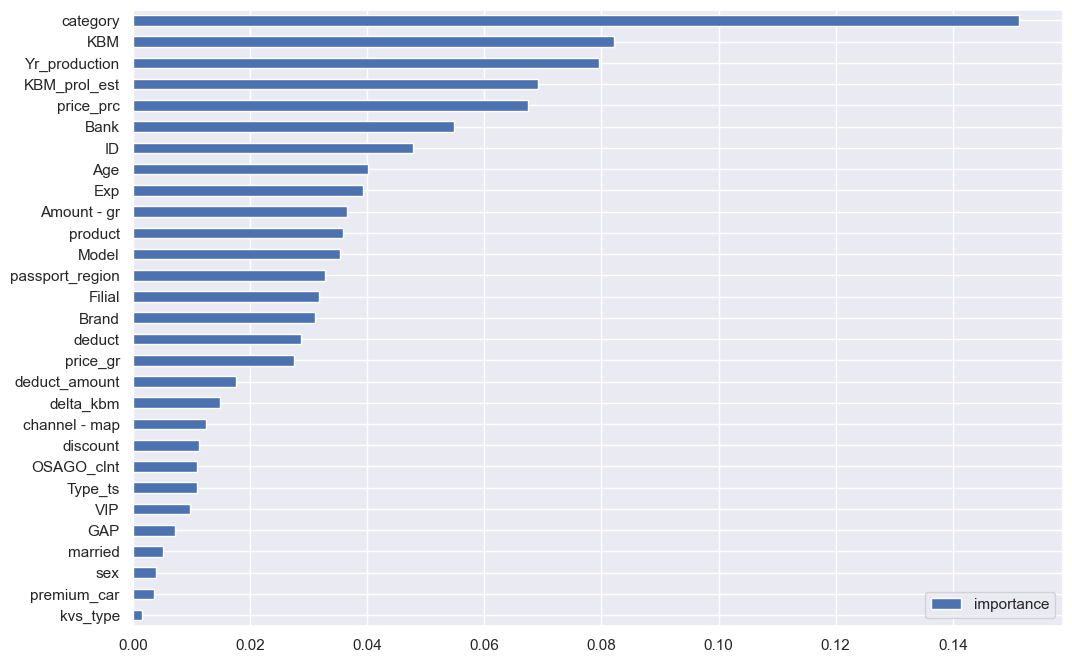

In [30]:
imp = pd.DataFrame(best_clf.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))


In [31]:
y_pred_proba=best_clf.predict_proba(X_test)
y_pred_proba


array([[0.73751656, 0.26248344],
       [0.86840167, 0.13159833],
       [0.68522089, 0.31477911],
       ...,
       [0.807424  , 0.192576  ],
       [0.68636329, 0.31363671],
       [0.56317657, 0.43682343]])

#### Метрики качества

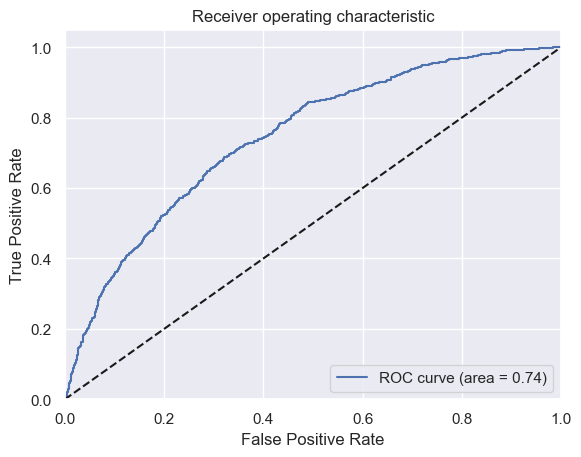

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr,# color='darkorange',
         #lw=lw, 
         label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] #, color='navy'
         #, lw=lw
         #, linestyle='--'
        , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [33]:
print('Precision: {}'.format(precision_score(best_clf.predict(X_test), y_test)))
print('Recall: {}'.format(recall_score(best_clf.predict(X_test), y_test)))
print('Accuracy: {}'.format(accuracy_score(best_clf.predict(X_test), y_test)))

Precision: 0.3069053708439898
Recall: 0.6451612903225806
Accuracy: 0.7312599681020734
